<a href="https://colab.research.google.com/github/CescaNeri/asai-er-ml/blob/main/ASAI_ER_2023_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio di programmazione Python - Parte 2

In questa parte di laboratorio si vedrà come utilizzare le funzionalità offerte da **scikit-learn** per risolvere un semplice problema di classificazione. Le nozioni imparate per risolvere il problema in questione sono ri-utilizzabili per risolvere problemi simili (regressione, clustering, ...) in quanto l'API di scikit-learn è uniforme.

# Scikit-learn
Scikit-learn è una libreria open source per Python che mette a disposizione numerose classi e funzionalità specifiche per il Machine Learning. Oltre a rendere disponibili i più comuni algoritmi per la classificazione, regressione e clustering, sono presenti anche diverse funzionalità per la manipolazione dei dati.

La popolarità di Scikit-learn è dovuta principalmente alla sua facilità d'uso, all'integrazione con la libreria NumPy e alla possibilità di parametrizzare le operazioni messe a disposizione, pur mantenendo una API semplice.

Per una lista completa delle funzionalità si rimanda alla [documentazione ufficiale](http://scikit-learn.org/stable/documentation.html).

# Import delle librerie
Per prima cosa è necessario eseguire l'import delle librerie utilizzate durante l'esecitazione. Il package della libreria Scikit-learn è denominato **sklearn**. Dal package è consigliato caricare solamente i moduli necessari.

In [1]:
# Moduli di scikit-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid, train_test_split

# Import NumPy
import numpy as np

# Import Matplotlib e Seaborn (visualizzazione dei risultati)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

# Dataset
Il dataset messo a disposizione consiste in un insieme di cifre (0-9) scritte a mano con un pennino su una tavoletta grafica.

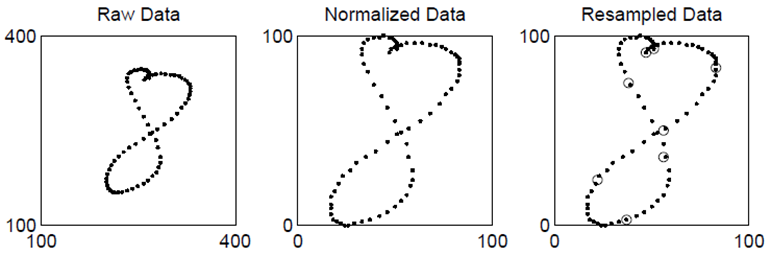

I dataset di training "pendigits_tr.txt" e "pendigits_tr_Pca_K2.txt" contengono entrambi 442 pattern etichettati (cifre da 0 a 9). Il primo contiene pattern 16-dimensionali (le coordinate x,y di otto punti equispaziati dopo normalizzazione e *resampling*) mentre il secondo consiste in una versione bidimensionale ottenuta tramite riduzione della dimensionalità mediante l'algoritmo *Principal Component Analysis* ([video con spiegazione seomplificata](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)).

Per questo laboratorio utilizzeremo esclusivamente la versione bi-dimensionale, utile per eseguire test iniziali visualizzando pattern e risultati.

Di seguito è fornita la procedura per il download e caricamento del dataset.



In [2]:
# Download dataset
!wget -nc http://bias.csr.unibo.it/maltoni/ml/Esercitazioni/Materiale/Dataset_kNN_Svm.zip
!unzip -o Dataset_kNN_Svm.zip

# Download dataset (Jupyter in locale, decommentare)
#import shutil
#import urllib.request
#urllib.request.urlretrieve("http://bias.csr.unibo.it/maltoni/ml/Esercitazioni/Materiale/Dataset_kNN_Svm.zip", "Dataset_kNN_Svm.zip")
#shutil.unpack_archive("Dataset_kNN_Svm.zip")

--2023-07-18 14:32:30--  http://bias.csr.unibo.it/maltoni/ml/Esercitazioni/Materiale/Dataset_kNN_Svm.zip
Resolving bias.csr.unibo.it (bias.csr.unibo.it)... 137.204.72.188
Connecting to bias.csr.unibo.it (bias.csr.unibo.it)|137.204.72.188|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180098 (176K) [application/x-zip-compressed]
Saving to: ‘Dataset_kNN_Svm.zip’

Dataset_kNN_Svm.zip 100%[===================>] 175.88K   387KB/s    in 0.5s    

2023-07-18 14:32:31 (387 KB/s) - ‘Dataset_kNN_Svm.zip’ saved [180098/180098]

Archive:  Dataset_kNN_Svm.zip
   creating: DBs/
   creating: DBs/PenDigits/
  inflating: DBs/PenDigits/pendigits_te.txt  
  inflating: DBs/PenDigits/pendigits_tr.txt  
  inflating: DBs/PenDigits/pendigits_te_Pca_K2.txt  
  inflating: DBs/PenDigits/pendigits_tr_Pca_K2.txt  


In [3]:
dataset_path = 'DBs/PenDigits/pendigits_tr_Pca_K2.txt'

# Caricamento del da utilizzando NumPy
dataset_patterns = np.loadtxt(dataset_path, usecols=range(0, 2))
dataset_labels = np.loadtxt(dataset_path, usecols=[2])

print('Shape data:', dataset_patterns.shape)
print('Shape labels:', dataset_labels.shape)

print('Primo esempio:\n', dataset_patterns[0])
print('Etichetta primo esempio:\n', dataset_labels[0])

Shape data: (442, 2)
Shape labels: (442,)
Primo esempio:
 [-130.04891   70.15043]
Etichetta primo esempio:
 5.0


## Preparazione del dataset

Il dataset è ottenuto sotto forma di array NumPy. Gli esempi sono memorizzati in `dataset_patterns` in formato matriciale: ogni riga corrisponde a un esempio descritto da 2 feature (colonne). I valori sono floating point. Le label invece sono un array monodimensionale con valori da 0 a 9.

Nota: si noti come NumPy abbia caricato anche le label come floating point anzichè interi. Questo però non si rivelerà essere un problema.

Il dataset caricato può essere suddiviso in due parti: training e validation set. Attraverso il validation set sarà possibile valutare i risultati del classificatore addestrato sul training set al fine di individuare il valore ottimale per gli iperparametri.

Visto che in Machine Learning è comune eseguire tale operazione, la libreria Scikit-learn mette a disposizione una apposita funzione, [**train_test_split(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), che permette di separare un dataset in due parti.

Il parametro *test_size* descrive la percentuale di pattern che dovrà essere contenuta nella seconda parte. Come configurazione predefinita **train_test_split(...)** mescola i pattern al fine di **evitare che i dataset restituiti contengano pattern appartenenti solamente a un sottoinsieme delle classi**.

Nota: il test set è reso già disponibile come file a parte, per cui dallo split otterremo un validation set, non il test set!

Chiamiamo `x` le feature degli esempi e `y` le etichette di classe.


In [4]:
# train_test_split ritorna 4 valori:
# 1. X del training (matrice Nx2)
# 2. X del validation (matrice Mx2)
# 3. Y del training (vettore di N elementi)
# 4. Y del validation (vettore di M elementi)
train_x, validation_x, train_y, validation_y = train_test_split(dataset_patterns, dataset_labels, test_size=0.40)
print('Shape training set:', train_x.shape)
print('Shape validation set:', validation_x.shape)

Shape training set: (265, 2)
Shape validation set: (177, 2)


Domanda 1: essendo `dataset_patterns` e `dataset_labels` degli array NumPy, **si sarebbe potuto eseguire lo split usando lo slicing sulle righe**. Quali sarebbero stati gli **svantaggi**?

Domanda 2: `train_test_split` mescola il dataset prima di esequire lo split. Questo ci assicura che tutte le classi siano opportunamente rappresentate sia nel train che nel validation set? Cosa succede se il dataset è piccolo e sbilanciato (diverso numero di esempi per le diverse classi)? Controllate la documentazione di [**train_test_split(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Esistono modi per migliorare lo split?

Domanda 3: cos'è il `random_state` che appare nella documentazione?

# Classificazione
Di seguito vengono descritte le operazioni necessarie per creare e addestrare un classificatore. Uno dei punti di forza della libreria scikit-learn è la sua facilità d'uso e l'uniformità delle chiamate alla libreria: si noti come queste operazioni necessitino solamente di due linee di codice.

Step 1: creazione del classificatore.

In [5]:
# Creazione di un classificatore
dummy_clf = DummyClassifier(strategy='most_frequent')

Nell'esempio, il classificatore creato è un **DummyClassifier** la cui strategia è quella di assegnare ad ogni pattern la classe più numerosa nel training set.

Il classificatore (*estimator* nel lessico di scikit-learn) può essere addestrato tramite il metodo **.fit(...)** che prende in input un insieme di pattern etichettati (cioè x e y). Il set di pattern di addestramento (X) devono essere memorizzati per righe in un NumPy array bidimensionale mentre le etichette (y) in un NumPy array monodimensionale. Questo vuol dire che i nostri `train_x` e `train_y` sono già pronti all'uso.

N.B.: la notazione X (maiuscolo) e y (minuscolo) è normalmente utilizzata in scikit-learn per indicare un set di pattern (X) e le rispettive etichette (y).

Step 2: addestramento

In [6]:
# Addestramento
dummy_clf.fit(train_x, train_y)

DummyClassifier(strategy='most_frequent')

Una volta addestrato, un classificatore può essere utilizzato per riconoscere la classe di uno o più pattern. Per fare ciò, si può utilizzare il metodo **.predict(...)** passando come parametro una lista di pattern. Il risultato che si ottiene è una lista delle label predette dal classificatore.

Nella cella seguente proviamo a classificare i primi 5 esempi del validation set:

In [7]:
# Uso della funzione .predict(...)
print('Classi predette:', dummy_clf.predict(validation_x[0:5]))
print('Classi reali:', validation_y[0:5])

Classi predette: [3. 3. 3. 3. 3.]
Classi reali: [3. 9. 6. 1. 6.]


In Scikit-learn è possibile misurare l'accuratezza di un classificatore su un determinato dataset richiamando il metodo **.score(...)** che prende in input un insieme di pattern etichettati X,y. Internamente il metodo classifica ogni singolo pattern di X e verifica se l'etichetta assegnata corrisponde alla corrispondente *entry* in y.

In [8]:
# Uso della funzione .score(...)
print('Accuratezza sul training set: %.3f' % dummy_clf.score(train_x, train_y))
print('Accuratezza sul validation set: %.3f' % dummy_clf.score(validation_x, validation_y))

Accuratezza sul training set: 0.158
Accuratezza sul validation set: 0.096


Per dati bidimensionali può essere utile visualizzare graficamente i pattern e la superfice decisionale del classificatore. Per fare ciò si può utilizzare la funzione **show_2D_results(...)** che definiamo di seguito. La funzione utilizzerà [Matplotlib](https://matplotlib.org/) e [Seaborn](https://seaborn.pydata.org/) per visualizzare i risultati. Entrambe le librerie sono molto utilizzate sia in ambito Machine Learning che Data Science/Data Analysis/...

Non copriamo queste librerie in questa lezione. Per ora ci limitiamo a eseguire la cella seguente per definire le funzioni necessarie.

In [9]:
def color_fading(colors, fadingFactor):
    fadedColors = []
    for c in colors:
        rgbColor = matplotlib.colors.to_rgb(c)
        fadedRgbColor = [fadingFactor * c1 + (1 - fadingFactor) * c2 for (c1, c2) in zip(rgbColor, (1, 1, 1))]
        fadedColors.append(matplotlib.colors.to_hex(fadedRgbColor))

    return fadedColors

def show_2D_results(clf, *datasets, figsize=(18, 8)):
  class_colors = ["red", "coral", "gold", "yellowgreen", "green", "mediumaquamarine",
                  "mediumturquoise", "cornflowerblue", "blue", "purple"]
  area_colors = color_fading(class_colors, 0.7)
  area_colors = ListedColormap(area_colors)

  fig, axs = plt.subplots(1, len(datasets), figsize=figsize, squeeze=False)
  axs = axs.flatten()
  for (x, y, name), ax in zip(datasets, axs):
    DecisionBoundaryDisplay.from_estimator(
        clf,
        x,
        cmap=area_colors,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
        vmin=0,
        vmax=9
    )

    sns.scatterplot(
        x=x[:, 0],
        y=x[:, 1],
        hue=y.astype(int),
        palette=class_colors,
        alpha=1.0,
        edgecolor="black",
        ax=ax
    )

  plt.show(fig)
  plt.close(fig)

Dopodichè possiamo usare la funzione appena definita per visualizzare il risultato del nostro classificatore sia sul train che sul validation set.

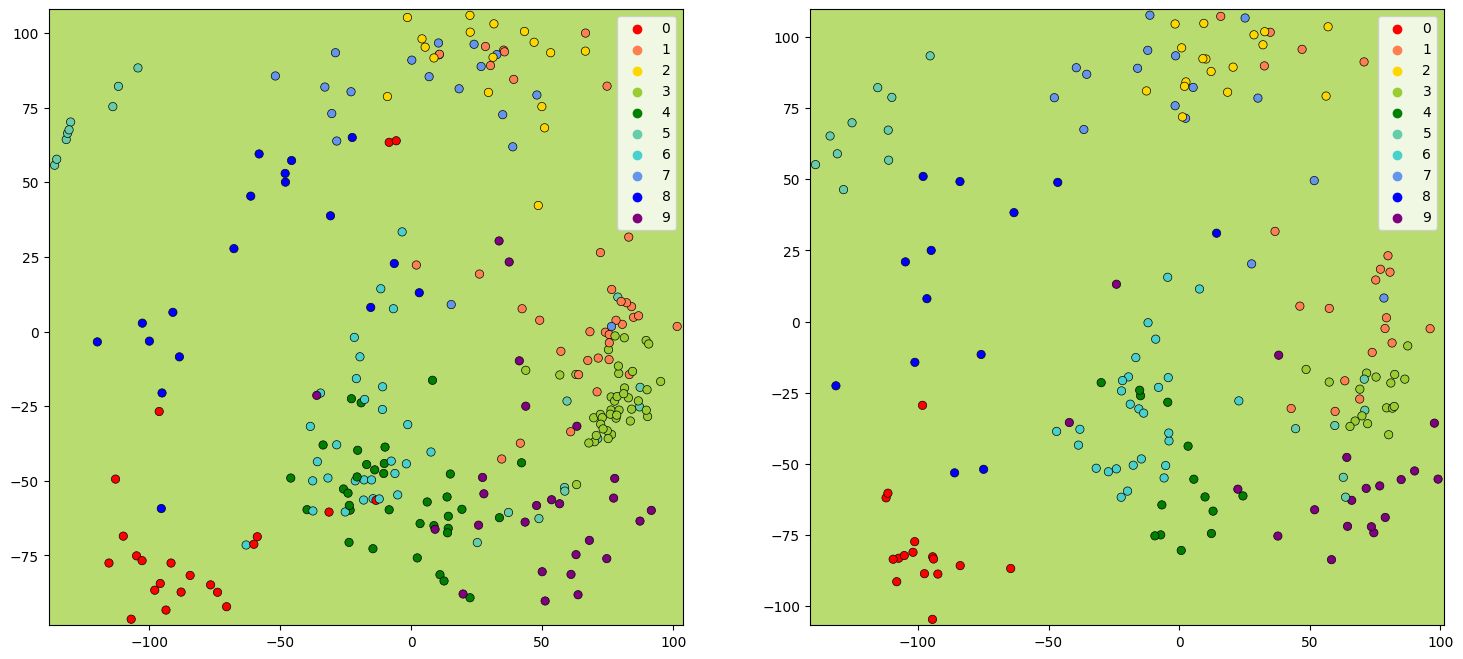

In [10]:
show_2D_results(dummy_clf, (train_x, train_y, 'Training'), (validation_x, validation_y, 'Validation'))

## k-NN e SVM
Abbiamo visto come, con Scikit-learn, sia possibile creare, addestrare e utilizzare un generico classificatore. Scikit-learn mette a disposizione una serie di classificatori tra cui [k-NN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) e [SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) che utilizzeremo per riconoscere i pattern caricati in precedenza.

Nell'esercizio seguente, si crei e addestri un classificatore. Si consiglia di provare sia kNN che SVM. Questo è un buon momento anche per prendere **confidenza con la documentazione offerta da scikit-learn**, per cui il cosiglio è quello di **provare diversi iperparametri** per capire quale combinazione potrebbe essere la migliore.

Si consiglia di osservare se ci sono particolari discrepanze tra l'accuracy sul training e sul validation set. Come mai potrebbe esserci una discrepanza molto marcata?

In [ ]:
# Esercizio: creare ed addestrare un classificatore

# clf = KNeighborsClassifier()
# clf = SVC(kernel="linear")
# clf = SVC(kernel="rbf")

# Addestramento del classificatore
# ...

# Calcolo accuratezza
print('Accuratezza sul training set: %.3f' % clf.score(train_x, train_y))
print('Accuratezza sul validation set: %.3f' % clf.score(validation_x, validation_y))

#Visualizzazione 2D
show_2D_results(clf, (train_x, train_y, 'Training'), (validation_x, validation_y, 'Validation'))

Accuratezza sul training set: 0.743
Accuratezza sul validation set: 0.695
Accuratezza sul training set: 0.611
Accuratezza sul validation set: 0.633
Accuratezza sul training set: 0.642
Accuratezza sul validation set: 0.667


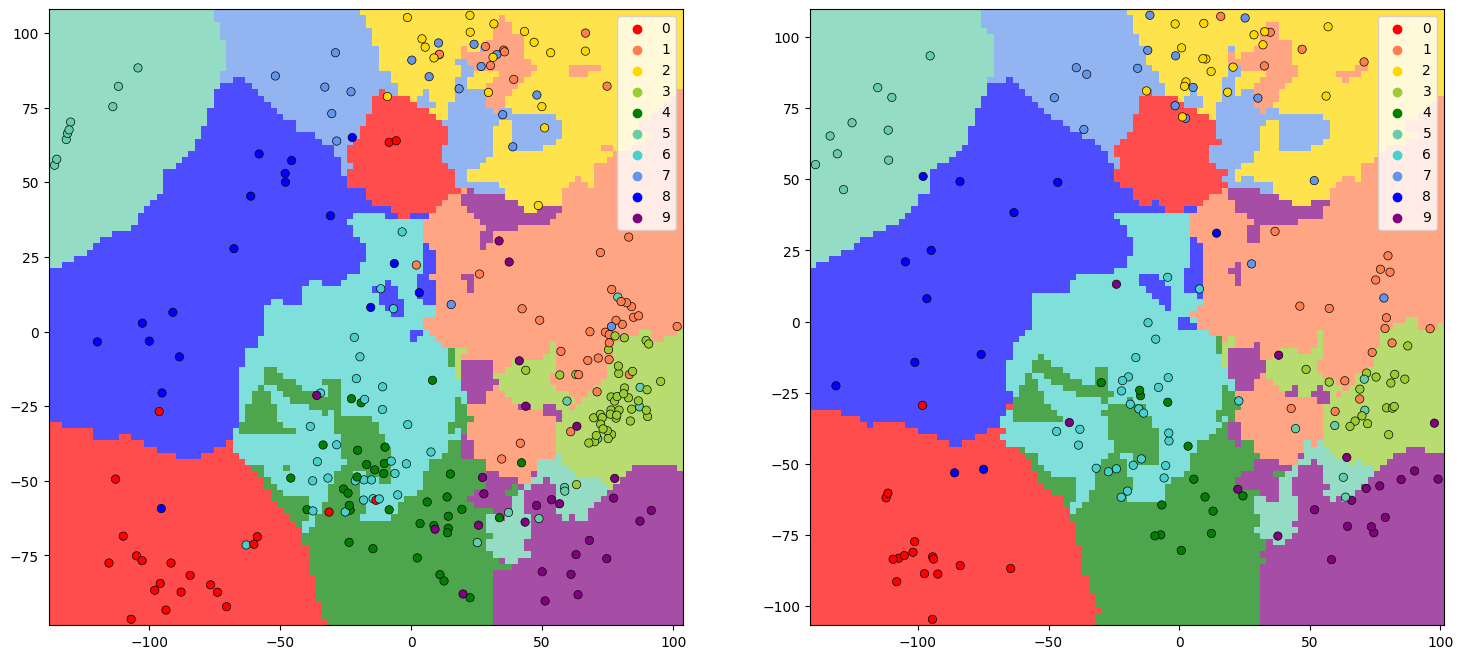

In [16]:
# Esercizio: creare ed addestrare un classificatore

clf_kn = KNeighborsClassifier()
clf_sl = SVC(kernel="linear")
clf_rbf = SVC(kernel="rbf")

# Addestramento del classificatore
clf_kn.fit(train_x, train_y)
clf_sl.fit(train_x, train_y)
clf_rbf.fit(train_x, train_y)

# Calcolo accuratezza
print('Accuratezza sul training set: %.3f' % clf_kn.score(train_x, train_y))
print('Accuratezza sul validation set: %.3f' % clf_kn.score(validation_x, validation_y))

print('Accuratezza sul training set: %.3f' % clf_sl.score(train_x, train_y))
print('Accuratezza sul validation set: %.3f' % clf_sl.score(validation_x, validation_y))

print('Accuratezza sul training set: %.3f' % clf_rbf.score(train_x, train_y))
print('Accuratezza sul validation set: %.3f' % clf_rbf.score(validation_x, validation_y))

#Visualizzazione 2D
# show_2D_results(clf_kn, (train_x, train_y, 'Training'), (validation_x, validation_y, 'Validation'))
# show_2D_results(clf_kn, (train_x, train_y, 'Training'), (validation_x, validation_y, 'Validation'))
show_2D_results(clf_kn, (train_x, train_y, 'Training'), (validation_x, validation_y, 'Validation'))

# Cross-Validation
In alcuni casi, specialmente in caso di dataset piccoli, si vorrebbe poter evitare di riservare un sottoinsieme disgiunto per il validation set al fine di sfruttare tutti i dati disponibili per training e validazione. In questo caso, può essere vantaggioso utilizzare la tecnica *Cross-Validation*.  

Lla cella seguente richia la funzione [**cross_val_score(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) di scikit-learn che stima l'accuratezza di un classificatore (*estimator*) tramite *Cross-Validation* (con un numero di *fold* pari a *cv*). La cross validation restituisce l'accuratezza ottenuta sulle diverse fold.

In [18]:
clf = SVC(kernel="rbf")

cv_score = cross_val_score(clf, dataset_patterns, dataset_labels)
print('Risultati CrossValidation:\n', cv_score)

Risultati CrossValidation:
 [0.71910112 0.62921348 0.68181818 0.64772727 0.73863636]


# Grid Search e Cross-Validation
Dato un algoritmo, la ricerca degli iperparametri ottimi può essere automatizzata utilizzando la classe [**GridSearchCV**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) messa a disposizione da scikit-learn.

Questo metodo è particolarmente indicato nei casi in cui l'addestramento di un classificatore non richieda un tempo particolarmente lungo.

L'idea è quella di definire i possibili valori di ogni iperparametri (dobbiamo definirli noi) e quindi provare tutte le combinazioni. Per ogni combinazione, al fine di verificarne le performance, viene eseguita la cross validation (quindi `fold` addestramenti).

Si consideri che in totale vengono creati e addestrati $(\textit{# combinazioni degli iperparametri} \times \textit{# fold})$ classificatori. A questo si aggiunge un addestramento finale eseguito sull'intero dataset utilizzando la combinazione migliore di iperparametri.

Di seguito è proposto un esempio in cui, utilizzando una SVM, vengono provate 4 combinazioni di iperparametri.

Combinazioni di parametri:
 [{'C': 1, 'gamma': 0.05, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.025, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.05, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.025, 'kernel': 'rbf'}]
Accuratezza media per combinazione:
 [0.49315131 0.59048845 0.49767114 0.56104063]
Combinazione migliore:
 {'C': 1, 'gamma': 0.025, 'kernel': 'rbf'}
Accuratezza media della combinazione migliore: 0.590


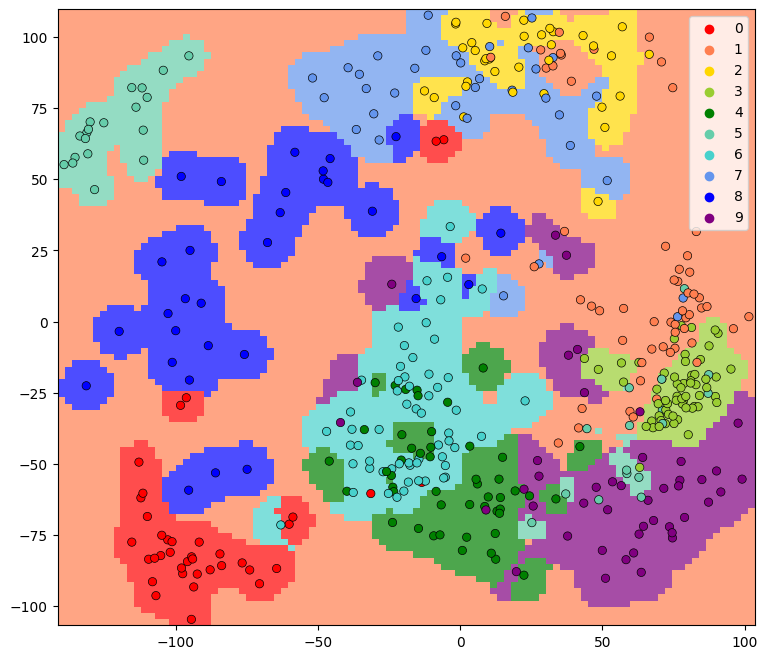

In [14]:
# Creazione di un classificatore di tipo SVM
clf = SVC()

# Creazione della griglia di iperparametri
param_grid = [{'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.05, 0.025]}]

# Numero di fold per la Cross-validation
n_folds = 3

# Creazione di un oggetto di tipo GridSearchCV
grid_search_cv = GridSearchCV(clf, param_grid, cv=n_folds)

# Esecuzione della ricerca degli iperparametri
grid_search_cv.fit(dataset_patterns, dataset_labels)

# Stampa risultati
print('Combinazioni di parametri:\n', grid_search_cv.cv_results_['params'])
print('Accuratezza media per combinazione:\n', grid_search_cv.cv_results_['mean_test_score'])
print('Combinazione migliore:\n', grid_search_cv.best_params_)
print('Accuratezza media della combinazione migliore: %.3f' % grid_search_cv.best_score_)

# Visualizzazione 2D
show_2D_results(
    grid_search_cv.best_estimator_,
    (dataset_patterns, dataset_labels, 'Data'),
    figsize=(9, 8)
)

# Esercizio finale
Come esercizio finale, si addestri un classificatore a scelta tra quelli disponibili in scikit-learn. Nelle celle precedenti abbiamo visto kNN e SVM, ma ce ne sono tanti altri pronti all'uso.

Potete modificare e aggiungere celle a piacimento. L'obiettivo è quello di trovare la combinazione `tipologia di classificatore`+`relativi iperparametri` con le performance migliori. I parametri di partenza infatti non sono ottimali e c'è un evidente problema di **overfitting**. Si consiglia di utilizzare la grid search con criterio, partendo da un insieme ristretto di combinazioni con valori molto distanziati per poi restringere il campo verso i valori migliori.

In scikit-learn esistono alternative alla grid search. Ad esempio, sarebbe possibile cercare gli iperparametri ottimali in un range di valori anzichè in una griglia fissa. Secondo voi, quali sono i pro e i contro? Per una lista completa dei sistemi di ricerca degli iperparametri in scikit-learn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

Maggiori info sulla ricerca di iperparametri: [qui](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) e [qui](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

Infine, se siete curiosi riguardo alle performance sul test set del classificatore ottenuto, potete inviare il vostro risultato [sulla piattaforma CodaLab](https://codalab.lisn.upsaclay.fr/competitions/14612?secret_key=440b9353-eb40-4a18-ba54-394d3c83a8cf). La piattaforma vi calcolerà il risultato sul test set, le cui etichette infatti non sono pubbliche per permettere una "competizione" più onesta. Si cerchi di ottenere un'accuratezza superiore al 65%! Massimo 2 tentativi.

Per ottenere il file da zippare e inviare, si completi in seguito `clf = ...` con il classificatore + iperparametri trovati. Maggiori indicazioni verranno comunicate in laboratorio.

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
# Valutazione su test set
result_path = 'Es3Predictions.txt'

# Caricamento del test set
test_path = 'DBs/PenDigits/pendigits_te_Pca_K2.txt'

test_x = np.loadtxt(test_path, usecols=range(0, 2))

# Creazione del classificatore
clf = RandomForestClassifier(max_depth=2, random_state=0)

# Addestramento del classificatore
clf.fit(dataset_patterns, dataset_labels)

# Calcolo delle prediction
predictions = clf.predict(test_x)

cv_score = cross_val_score(clf, dataset_patterns, dataset_labels)
print('Risultati CrossValidation:\n', cv_score)

# Salvataggio delle prediction
with open(result_path, "w") as f:
    for prediction in predictions:
        f.write(str(int(prediction)) + '\n')
print('Salvataggio delle prediction riuscito')



Risultati CrossValidation:
 [0.59550562 0.52808989 0.61363636 0.52272727 0.625     ]
Salvataggio delle prediction riuscito


# Ulteriori lezioni

Il sito del corso di Machine Learning della Laurea Magistrale in Ingegneria e Scienze Informatiche (Cesena, UniBo) mette a disposizione diverse lezioni di laboratorio che coprono questi e altri argomenti (regressione, clustering, computer vision, riconoscimento vocale). Se volete approfondire, il materiale di laboratorio è liberamente accessibile, tutto sotto foma di notebook: http://bias.csr.unibo.it/maltoni/ml/